In [54]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import confusion_matrix
import sounddevice as sd
from timeit import default_timer as timer
import python_speech_features
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [55]:
# Create list of all targets (minus background noise)
dataset_path = './recordingTest'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['backgroundNoise', 'ㄏㄧㄡ', 'ㄟ', '他', '你', '吼', '啦', '嗯', '好', '我', '的', '著', '那', '阿']


In [56]:
# Settings
feature_sets_path = './npz/'
feature_sets_filename = 'recordingTest.npz'
model_filename = './h5/recordingTest.h5'

In [57]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [58]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']
print(y_test)
print(y_train)
print(y_val)

[10.  1.  2. ...  4.  6.  7.]
[11. 12. 11. ...  6.  6.  3.]
[4. 2. 9. ... 9. 3. 9.]


In [59]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(9972, 49, 26)
(3323, 49, 26)
(3323, 49, 26)


In [60]:
# Peek at labels
print(y_val)

[4. 2. 9. ... 9. 3. 9.]


In [61]:
# Peek at labels after conversion
print(y_test)

[10.  1.  2. ...  4.  6.  7.]


In [62]:
# View the dimensions of our input data
print(x_train.shape)

(9972, 49, 26)


In [63]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(9972, 49, 26, 1)
(3323, 49, 26, 1)
(3323, 49, 26, 1)


In [64]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(49, 26, 1)


In [68]:
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(1, 1)))
model.add(layers.Dropout(0.2))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(14, activation='softmax'))
# Display model
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 25, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 11, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 5, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 4, 128)        32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 4, 128)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 4, 128)       

In [69]:
from tensorflow.keras import optimizers
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [70]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=50,
                    batch_size=50,
                    validation_data=(x_val, y_val))

Epoch 1/50
200/200 [==============================] - 4s 17ms/step - loss: 2.1709 - acc: 0.2786 - val_loss: 1.4453 - val_acc: 0.5408
Epoch 2/50
200/200 [==============================] - 3s 16ms/step - loss: 1.2480 - acc: 0.5818 - val_loss: 0.8280 - val_acc: 0.7505
Epoch 3/50
200/200 [==============================] - 3s 16ms/step - loss: 0.9256 - acc: 0.6882 - val_loss: 0.6393 - val_acc: 0.8011
Epoch 4/50
200/200 [==============================] - 3s 16ms/step - loss: 0.7601 - acc: 0.7390 - val_loss: 0.5182 - val_acc: 0.8324
Epoch 5/50
200/200 [==============================] - 3s 16ms/step - loss: 0.6610 - acc: 0.7719 - val_loss: 0.4792 - val_acc: 0.8444
Epoch 6/50
200/200 [==============================] - 3s 16ms/step - loss: 0.5866 - acc: 0.7983 - val_loss: 0.4346 - val_acc: 0.8559
Epoch 7/50
200/200 [==============================] - 3s 16ms/step - loss: 0.5302 - acc: 0.8144 - val_loss: 0.4026 - val_acc: 0.8643
Epoch 8/50
200/200 [==============================] - 3s 16ms/step - 

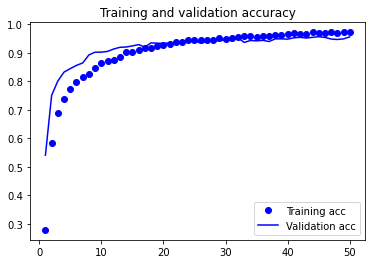

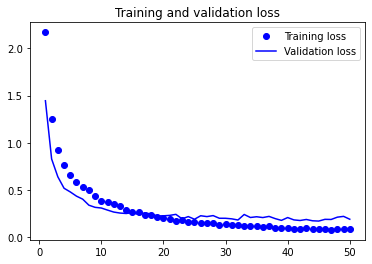

In [71]:
# Plot results


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
# Save the model as a file
models.save_model(model, model_filename)

In [73]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(0, 10):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 10.0  Prediction: [[7.9138390e-14 4.1642148e-09 1.8335514e-10 1.3205404e-12 2.5390633e-14
  7.8136070e-17 3.4301359e-13 2.3478716e-08 5.4587733e-17 2.1299454e-17
  9.9836248e-01 1.6374657e-03 4.2003182e-13 7.2087877e-16]]
Answer: 1.0  Prediction: [[1.3022298e-19 1.0000000e+00 2.1738687e-11 1.0489520e-13 4.4648831e-14
  8.5269447e-10 1.2673336e-12 6.0708640e-23 4.9040529e-21 7.7312608e-13
  3.2257039e-13 7.6524558e-11 2.2639619e-14 2.1297440e-20]]
Answer: 2.0  Prediction: [[5.7646526e-12 5.7211094e-09 9.9999809e-01 1.5981842e-08 1.9553408e-15
  1.0335802e-09 1.1436968e-19 5.8099372e-14 1.8745098e-06 7.5668367e-15
  9.5361366e-12 2.1985269e-13 1.5286514e-17 1.1674028e-11]]
Answer: 11.0  Prediction: [[2.1285280e-18 1.0265041e-12 1.5288244e-12 5.1213719e-16 2.1517278e-12
  1.4748529e-21 1.9141988e-16 1.0307605e-14 5.7104284e-23 1.4100253e-25
  2.4462148e-09 1.0000000e+00 2.4688178e-16 4.7061820e-24]]
Answer: 2.0  Prediction: [[6.08431178e-15 2.90030103e-17 1.00000000e+00 4.59495902

In [74]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

104/104 [==============================] - 1s 6ms/step - loss: 0.2353 - acc: 0.9464


[0.23526084423065186, 0.946433961391449]

C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12559 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12583 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20182 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\r6017\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20320 missing from c

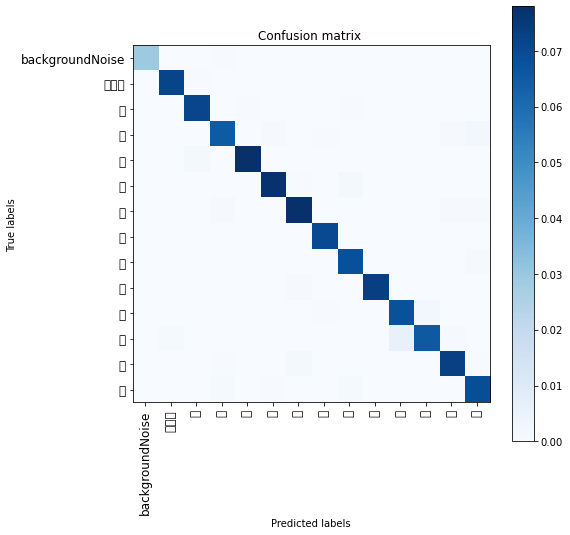

In [75]:
# plot confusion matrix
y = np.argmax(model.predict(x_val), axis=1)
cm = confusion_matrix(y_val, y,  normalize="all")
%matplotlib inline
plt.close()
plt.figure(figsize = (8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(0, 14, 1), all_targets, rotation=90)
plt.yticks(np.arange(0, 14, 1), all_targets)
plt.tick_params(labelsize=12)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [76]:
# compute MFCC features from audio signal
def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio = (audio - audio.mean()) / (audio.max() - audio.min())
    # compute MFCC coefficients
    features = python_speech_features.base.logfbank(audio, samplerate=16000, winlen=0.025, winstep=0.01, nfilt=26, nfft=512, lowfreq=0, highfreq=None, preemph=0.97)
    return features

In [77]:
def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]

[2.8753463e-10 3.9182536e-29 4.0036877e-11 1.4779015e-02 3.2432798e-23
 5.9985078e-15 2.4821648e-19 1.2346031e-08 1.9921285e-07 1.5870718e-22
 1.7050922e-13 1.4654118e-23 1.5007216e-11 9.8522079e-01]
1.0
candidates:
-----------------------------
1.)	阿	:	98.5%
2.)	他	:	1.5%
3.)	好	:	0.0%
-----------------------------
feature computation time: 2.2 ms
CNN model prediction time: 46.6 ms
total time: 48.7 ms


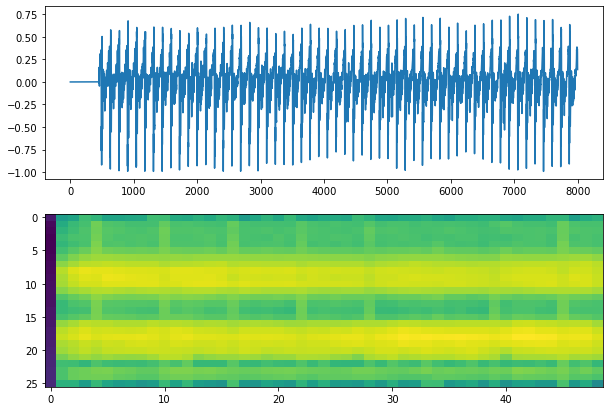

In [82]:
sd.default.samplerate = 16000
sd.default.channels = 1, 2 # mono record, stereo playback

recording = sd.rec(int(3*sd.default.samplerate), channels=1, samplerate=sd.default.samplerate, dtype=np.float, blocking=True)
recording = extract_loudest_section(recording, int(0.5*sd.default.samplerate)) # extract 1s snippet with highest energy (only necessary if recording is >3s long)
sd.play(recording, blocking=True)

t1 = timer()
recorded_feature = audio2feature(recording)
t2 = timer()

recorded_feature = np.float32(recorded_feature.reshape(1, recorded_feature.shape[0], recorded_feature.shape[1], 1))
prediction = model.predict(recorded_feature).reshape((14, ))
print(prediction)
print(prediction.sum())
t3 = timer()
# normalize prediction output to get "probabilities"
prediction /= prediction.sum()

# print the 3 candidates with highest probability
prediction_sorted_indices = prediction.argsort()
print("candidates:\n-----------------------------")
for k in range(3):
    i = int(prediction_sorted_indices[-1-k])
    print("%d.)\t%s\t:\t%2.1f%%" % (k+1, all_targets[i], prediction[i]*100))
print("-----------------------------")
print("feature computation time: %2.1f ms" % ((t2-t1)*1e3))
print("CNN model prediction time: %2.1f ms" % ((t3-t2)*1e3))
print("total time: %2.1f ms" % ((t3-t1)*1e3))

plt.close()
plt.figure(1, figsize=(10, 7))
plt.subplot(211)
plt.plot(recording)
plt.subplot(212)
plt.imshow(recorded_feature.reshape(49, 26).T, aspect="auto")
plt.show()